In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Data Load

In [2]:
#load data
ticket_sales=pd.read_csv('./Data_Input/ticket_sales.csv')
ticket_scans=pd.read_csv('./Data_Input/ticket_scans.csv')
game_info=pd.read_csv('./Data_Input/game_info.csv')
game_data=pd.read_csv('./Data_Input/game_data.csv')


In [3]:
#get shapes of dataframes
print (ticket_sales.shape)
print (ticket_scans.shape)
print (game_info.shape)
print (game_data.shape)

(6481699, 8)
(5541719, 5)
(242, 6)
(486, 51)


# Data Cleaning

In [8]:
#dropping csv index column
ticket_sales.drop('Unnamed: 0', axis=1,inplace=True)
ticket_scans.drop('Unnamed: 0', axis=1, inplace=True)

In [9]:
#converting dates in all dataframes from string to datetime objects

# game_info['game_date']=pd.to_datetime(game_info['game_date'], infer_datetime_format=True)
game_info['game_date']=pd.to_datetime(game_info['game_date'], format='%Y-%m-%d').dt.date

# ticket_sales['game_date']=pd.to_datetime(ticket_sales['game_date'], infer_datetime_format=True)
ticket_sales['game_date']=pd.to_datetime(ticket_sales['game_date'], format='%Y-%m-%d').dt.date

# ticket_sales['purchase_date']=pd.to_datetime(ticket_sales['purchase_date'], infer_datetime_format=True)
ticket_sales['purchase_date']=pd.to_datetime(ticket_sales['purchase_date'], format='%Y-%m-%d').dt.date

# ticket_scans['game_date']=pd.to_datetime(ticket_scans['game_date'], infer_datetime_format=True)
ticket_scans['game_date']=pd.to_datetime(ticket_scans['game_date'], format='%Y-%m-%d').dt.date


In [10]:
#fix date error on ticket_sales. There are 9 entries for game_date 2018-04-16 which should read 2018-04-17 as that was the date of the double header
ticket_sales['game_date']=np.where(ticket_sales['game_date']==dt.date(2018, 4, 16), dt.date(2018, 4, 17), ticket_sales['game_date'])

In [11]:
#Assumption: There are N/A entries in ticket_scans for section, row, seat. I am getting rid of these scans
ticket_scans=ticket_scans[(ticket_scans['section'].notnull()) | (ticket_scans['row'].notnull()) | (ticket_scans['seat'].notnull())]
ticket_scans.shape

(5262332, 4)

In [12]:
#removing duplicates on ticket_scans dataframe as there were some tickets scanned multiple times per game.
#only need to know if the customer attended the game, therefore knowing it was scanned at least once will suffice.
ticket_scans.drop_duplicates(keep='first',inplace=True)
ticket_scans.shape

(5260703, 4)

In [13]:
#creating a column in ticket_scans called 'ticket_scanned' with an entry of 1 for all rows as all tickets were scanned.
#Important for merge with ticket_sales to determine which tickets were purchased but not scanned
ticket_scans['ticket_scanned']=1
ticket_scans.head()

,game_date,section,row,seat,ticket_scanned
0,2017-08-09,105R,8,10.0,1
1,2017-08-09,524BR,14,7.0,1
2,2017-08-09,523L,7,106.0,1
3,2017-08-09,532L,17,106.0,1
4,2017-08-09,244R,3,4.0,1


In [14]:
#convert column 'row' values to string in ticket_sales as it was mixed str and int
#and would not merge properly with ticket_scans with has 'row' column values as string.
ticket_sales['row']=ticket_sales['row'].astype(str)

In [15]:
#find the number of tickets_scanned that are not in the ticket_sales dataframe. This number is important for a later merge.
unmatched_scans=pd.merge(ticket_sales, ticket_scans, on=['game_date', 'section', 'row', 'seat'], how='right')
unmatched_scans=unmatched_scans[unmatched_scans['acct_id'].isnull()]
unmatched_scans.shape

(104890, 8)

In [16]:
#left merge ticket_sales with ticket_scans on game_date,section, row, seat. Filling in 0 where ticket was not scanned
ticket_sales=pd.merge(ticket_sales, ticket_scans, on=['game_date', 'section', 'row', 'seat'], how='left').fillna(0)
print (ticket_sales.shape)
ticket_sales.head()

(6481699, 8)


,acct_id,game_date,purchase_date,section,row,seat,ticket_type,ticket_scanned
0,19268674.0,2019-06-04,2019-03-26,520R,3,10,Single Games,1.0
1,19272965.0,2019-06-04,2019-05-24,135L,5,102,Single Games,1.0
2,19272965.0,2019-06-04,2019-05-24,135L,5,103,Single Games,1.0
3,19273838.0,2019-06-04,2019-05-29,126L,28,111,Single Games,0.0
4,19276636.0,2019-06-04,2019-03-26,520R,3,5,Single Games,1.0


In [17]:
#the number of ticket_scans in theticket_sales dataframe
print(ticket_sales[ticket_sales['ticket_scanned']==1].shape)
#this difference should be around 104890
print (5260703-5155821)

(5155821, 8)
104882


In [18]:
#convert game_time_local to datetime object in game_date column in game_data dataframe
game_data['game_date']=pd.to_datetime(game_data['game_time_local'], format='%Y-%m-%d').dt.date
#sort game_data by game date and reset index
game_data.sort_values('game_date', inplace=True)
game_data.reset_index(drop=True, inplace=True)

In [19]:
#creation of 2 columns: TOR_wins, TOR_loses enter 0,1 respectively
game_data['wins']=np.where(game_data['wp_team_code']=='TOR', 1, 0)
game_data['lose']=np.where(game_data['lp_team_code']=='TOR', 1, 0)

In [21]:
#create a winning streak and losing streak and streak column for Blue Jays 
grouper=(game_data['wins']!=game_data['wins'].shift()).cumsum()
game_data['win_streak']=game_data['wins'].groupby(grouper).cumsum()

grouper=(game_data['lose']!=game_data['lose'].shift()).cumsum()
game_data['losing_streak']=game_data['lose'].groupby(grouper).cumsum()

game_data['streak']=game_data['win_streak']-(game_data['losing_streak'])

In [22]:
#get series game number in the context of TOR (all home and away games)
game_data['away_game']=np.where(game_data['away_team_code']=='TOR', 1, 0)
game_data['home_game']=np.where(game_data['home_team_code']=='TOR', 1, 0)

game_data['series_nbr']=np.where(game_data['away_game']==1, game_data['away_series_nbr'], game_data['home_series_nbr'])

In [24]:
#condense game_data dataframe into pertinent columns
game_data=game_data[['away_team_code',
           'home_team_code',
           'game_date',
           'double_header',
           'day_night_code',
           'game_elapsed_minutes',
           'wins',
           'lose',
           'win_streak',
           'losing_streak',
           'streak',
           'away_game',
           'home_game',
           'series_nbr']]

In [25]:
#merge game_data and game_info to get games only pertinent to Rogers Center
print(game_info.shape)
print(game_data.shape)

game_df=pd.merge(game_info, game_data, on=['game_date'], how='left')
print(game_df.shape)

(242, 6)
(486, 14)
(243, 19)


In [26]:
#because there was a delta of 1 row (243 to 244 rows) during merge, 
#that means that one row was added because of the Double_Header game on 04/17/2018
game_df[game_df['double_header']=='Y']

,game_date,game_time,opponent,holiday,giveaway_item,event,away_team_code,home_team_code,double_header,day_night_code,game_elapsed_minutes,wins,lose,win_streak,losing_streak,streak,away_game,home_game,series_nbr
88,2018-04-17,19:07:00,KCR,NaN,NaN,NaN,KC,TOR,Y,D,176.0,1,0,2,0,2,0,1,6
89,2018-04-17,19:07:00,KCR,NaN,NaN,NaN,KC,TOR,Y,D,217.0,1,0,3,0,3,0,1,6


In [27]:
#Consolidate the Double Headers by keeping last game of the double_header
game_df.drop_duplicates(subset=['game_date', 'double_header'], keep='last', inplace=True)

In [28]:
print (game_df.shape)
game_df[game_df['double_header']=='Y']

(242, 19)


,game_date,game_time,opponent,holiday,giveaway_item,event,away_team_code,home_team_code,double_header,day_night_code,game_elapsed_minutes,wins,lose,win_streak,losing_streak,streak,away_game,home_game,series_nbr
89,2018-04-17,19:07:00,KCR,NaN,NaN,NaN,KC,TOR,Y,D,217.0,1,0,3,0,3,0,1,6


In [31]:
#consolidate game_df to pertinent columns
game_df=game_df[['game_date',
                 'game_time',
                 'opponent',
                 'holiday',
                 'giveaway_item',
                 'event',
                 'double_header',
                 'day_night_code',
                 'game_elapsed_minutes',
                 'wins',
                 'lose',
                 'streak',
                 'series_nbr']]

In [32]:
#fixing day_night_code on game_df for D (13:07:00, 12:37:00), A (15:37:00, 15:07:00, 16:07:00), and E (19:07:00)
game_df.loc[(game_df.game_time == '12:37:00') | (game_df.game_time == '13:07:00'), 'day_night_code'] = 'D'  
game_df.loc[(game_df.game_time == '15:37:00') | (game_df.game_time == '15:07:00') | (game_df.game_time == '16:07:00'), 'day_night_code'] = 'A'
game_df.loc[(game_df.game_time == '19:07:00') , 'day_night_code'] = 'E'  

In [33]:
#on game_df, assign 1 for holiday, giveaway_item and event if applicable and 0 if not applicable (null) 
game_df.loc[game_df['holiday'].notnull(), 'holiday']=1
game_df.loc[game_df['giveaway_item'].notnull(), 'giveaway_item']=1
game_df.loc[game_df['event'].notnull(), 'event']=1
game_df[['holiday', 'giveaway_item', 'event']]=game_df[['holiday', 'giveaway_item', 'event']].fillna(0)

In [34]:
#merge ticket sales with game_df on game_df
all_data=pd.merge(ticket_sales, game_df, on='game_date', how='left')
all_data.sort_values('game_date', inplace=True)
all_data.reset_index(drop=True, inplace=True)
print (all_data.shape)

(6481699, 20)


In [35]:
#convert all_data dates from dt.date to datetime objects
all_data['game_date']=pd.to_datetime(all_data['game_date'])
all_data['purchase_date']=pd.to_datetime(all_data['purchase_date'])

In [36]:
all_data.head()

,acct_id,game_date,purchase_date,section,row,seat,ticket_type,ticket_scanned,game_time,opponent,holiday,giveaway_item,event,double_header,day_night_code,game_elapsed_minutes,wins,lose,streak,series_nbr
0,4309949.0,2017-04-11,2016-11-07,516L,19,106,Game Pack,0.0,19:07:00,MIL,0,1,0,N,E,211.0,0,1,-4,3
1,7292203.0,2017-04-11,2017-02-23,113CL,25,108,Single Games,0.0,19:07:00,MIL,0,1,0,N,E,211.0,0,1,-4,3
2,7292203.0,2017-04-11,2017-02-23,113CL,25,109,Single Games,1.0,19:07:00,MIL,0,1,0,N,E,211.0,0,1,-4,3
3,7292203.0,2017-04-11,2017-02-23,113CL,25,110,Single Games,0.0,19:07:00,MIL,0,1,0,N,E,211.0,0,1,-4,3
4,7292203.0,2017-04-11,2017-02-23,113CL,26,101,Single Games,1.0,19:07:00,MIL,0,1,0,N,E,211.0,0,1,-4,3


# Feature Engineering

In [37]:
#get column for day of the week (dow) for game_date and purchase_date
all_data['game_date_dow']=all_data['game_date'].apply(lambda x: x.weekday())
all_data['purchase_date_dow']=all_data['purchase_date'].apply(lambda x: x.weekday())

# get column for month for game_date and purchase_date
all_data['game_month']=all_data['game_date'].apply(lambda x: x.month)
all_data['purchase_month']=all_data['purchase_date'].apply(lambda x: x.month)

#get column for _isEndWeek for game_date and purchase date are a Sat or Sun
all_data['game_date_isEndWeek']=all_data["game_date_dow"].apply(lambda x: 1 if x >= 5 else 0)
all_data['purchase_date_isEndWeek']=all_data["purchase_date_dow"].apply(lambda x: 1 if x >= 5 else 0)

#get a column for delta between game_date and purchase_date
all_data['purchase_date_delta']=all_data['game_date']-all_data['purchase_date']

In [38]:
#create column called purchased_during win_streak which will populate a 1,
#if all_data['purchase_date'] value equals game_df['game_date'] with a streak >=3
all_data['on_win_streak']=np.where(all_data['streak']>=3, 1, 0)
all_data['purchase_on_winStreak']=np.where((all_data['purchase_date'].isin(game_df['game_date'].values)) & (all_data['on_win_streak']==1), 1, 0)

In [39]:
#create column called purchased_during lose_streak which will populate a 1,
#if all_data['purchase_date'] value equals game_df['game_date'] with a streak <=-4
all_data['on_lose_streak']=np.where(all_data['streak']<=-4, 1, 0)
all_data['purchase_on_loseStreak']=np.where((all_data['purchase_date'].isin(game_df['game_date'].values)) & (all_data['on_win_streak']==1), 1, 0)

In [40]:
#remove rows from all_data where purchase_date_delta is negative (i.e. the purchase date is after the game _date)
print (all_data[all_data['purchase_date_delta']<'0 days'].shape)
print (all_data.shape)
all_data=all_data[all_data['purchase_date_delta']>='0 days']
print (all_data.shape)

(11366, 31)
(6481699, 31)
(6470333, 31)


In [41]:
#create a column for last_minute_buyer (if the purchase was made 14 days before the game)
all_data['last_minute_buyer']=np.where(all_data['purchase_date_delta']<='14 days', 1, 0)
#create a column for 30_day_buyer (if the purchase was made 30 days before the game)
all_data['30_day_buyer']=np.where(all_data['purchase_date_delta']<='30 days', 1, 0)


In [42]:
#100, 200, 500 level seat
all_data['section_500'] = np.where((all_data['section'].astype(str).str[0])=='5', 1, 0)
all_data['section_200'] = np.where((all_data['section'].astype(str).str[0])=='2', 1, 0)
all_data['section_100'] = np.where((all_data['section'].astype(str).str[0])=='1', 1, 0)

all_data['section_desc']=all_data['section_500']*500 + all_data['section_200']*200 + all_data['section_100']*100 

In [43]:
all_data.head()

,acct_id,game_date,purchase_date,section,row,seat,ticket_type,ticket_scanned,game_time,opponent,...,on_win_streak,purchase_on_winStreak,on_lose_streak,purchase_on_loseStreak,last_minute_buyer,30_day_buyer,section_500,section_200,section_100,section_desc
0,4309949.0,2017-04-11,2016-11-07,516L,19,106,Game Pack,0.0,19:07:00,MIL,...,0,0,1,0,0,0,1,0,0,500
1,7292203.0,2017-04-11,2017-02-23,113CL,25,108,Single Games,0.0,19:07:00,MIL,...,0,0,1,0,0,0,0,0,1,100
2,7292203.0,2017-04-11,2017-02-23,113CL,25,109,Single Games,1.0,19:07:00,MIL,...,0,0,1,0,0,0,0,0,1,100
3,7292203.0,2017-04-11,2017-02-23,113CL,25,110,Single Games,0.0,19:07:00,MIL,...,0,0,1,0,0,0,0,0,1,100
4,7292203.0,2017-04-11,2017-02-23,113CL,26,101,Single Games,1.0,19:07:00,MIL,...,0,0,1,0,0,0,0,0,1,100


# Data Exploration TICKET SALES

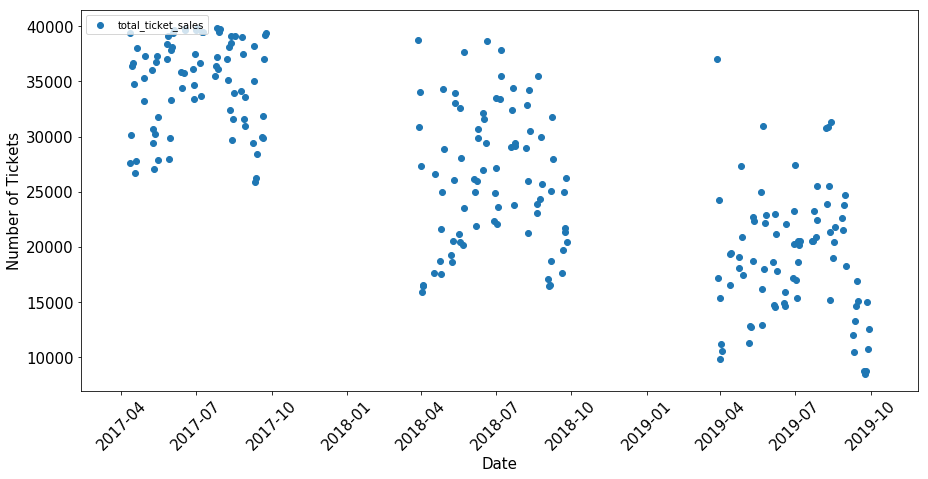

In [44]:
#plot ticket sales by game date
df_1=all_data.groupby(['game_date']).agg({'acct_id':np.size,
                                          'ticket_scanned':np.sum}).rename(columns={'acct_id': 'total_ticket_sales',
                                                                                    'ticket_scanned': 'total_tickets_scanned'})

fig=plt.figure(figsize=(15,7))
ax1=fig.add_subplot(111)
ax1.scatter(x=df_1.index, y=df_1['total_ticket_sales'])
# ax1.scatter(x=df_1.index, y=df_1['total_tickets_scanned'])
plt.legend(loc='upper left')
plt.xlabel('Date', size=15)
plt.ylabel('Number of Tickets', size=15)
plt.yticks(size=15)
plt.xticks(size=15, rotation=45)
plt.show()

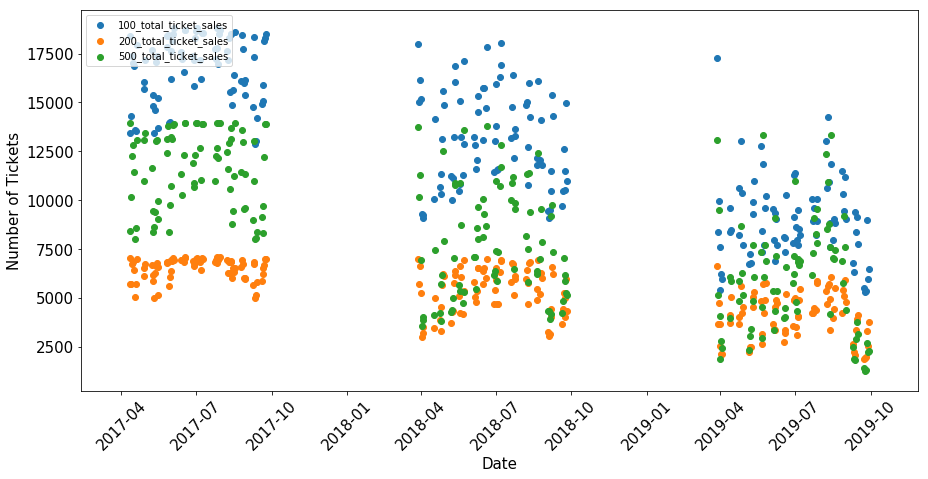

In [47]:
#plot ticket sales by game date (broken by section 100, 200, 500)
df_100 = all_data[all_data['section_100']==1]
df_200 = all_data[all_data['section_200']==1]
df_500 = all_data[all_data['section_500']==1]
df_1=df_100.groupby(['game_date']).agg({'acct_id':np.size,
                                          'ticket_scanned':np.sum}).rename(columns={'acct_id': '100_total_ticket_sales',
                                                                                    'ticket_scanned': 'total_tickets_scanned'})
df_2=df_200.groupby(['game_date']).agg({'acct_id':np.size,
                                          'ticket_scanned':np.sum}).rename(columns={'acct_id': '200_total_ticket_sales',
                                                                                    'ticket_scanned': 'total_tickets_scanned'})
df_5=df_500.groupby(['game_date']).agg({'acct_id':np.size,
                                          'ticket_scanned':np.sum}).rename(columns={'acct_id': '500_total_ticket_sales',
                                                                                    'ticket_scanned': 'total_tickets_scanned'})

fig=plt.figure(figsize=(15,7))
ax1=fig.add_subplot(111)
for i in [1,2,5]:
    exec("ax1.scatter(x=df_{0}.index, y=df_{0}['{0}00_total_ticket_sales'])".format(i))
    plt.legend(loc='upper left')
    plt.xlabel('Date', size=15)
    plt.ylabel('Number of Tickets', size=15)
    plt.yticks(size=15)
    plt.xticks(size=15, rotation=45)
plt.show()

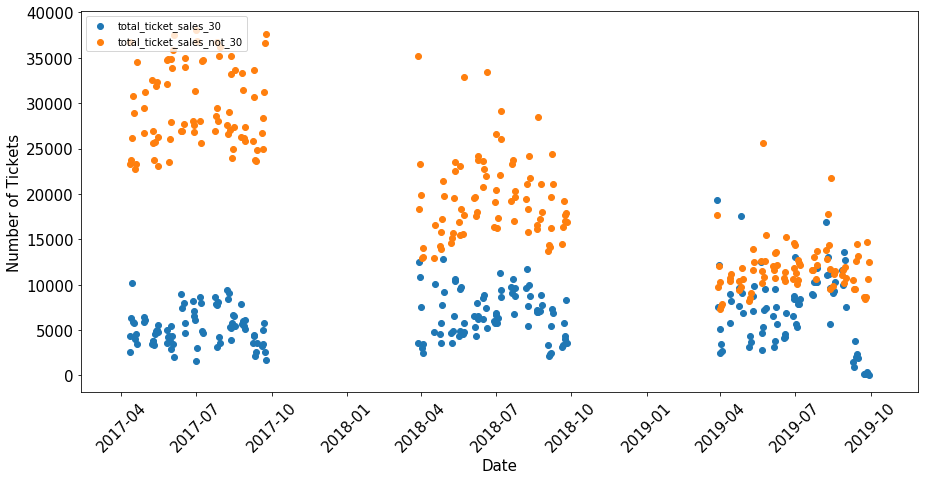

In [54]:
#plot tickets sold (broken up by whether ticket was purchased within 30 days prior to game or earlier than 30 days prior)
df_not_last30 = all_data[all_data['30_day_buyer']==0]
df_last30 = all_data[all_data['30_day_buyer']==1]

df_30=df_last30.groupby(['game_date']).agg({'acct_id':np.size,
                                          'ticket_scanned':np.sum}).rename(columns={'acct_id': 'total_ticket_sales_30',
                                                                                    'ticket_scanned': 'total_tickets_scanned'})
df_not_30=df_not_last30.groupby(['game_date']).agg({'acct_id':np.size,
                                          'ticket_scanned':np.sum}).rename(columns={'acct_id': 'total_ticket_sales_not_30',
                                                                                    'ticket_scanned': 'total_tickets_scanned'})

fig=plt.figure(figsize=(15,7))
ax1=fig.add_subplot(111)
for i in ['30', 'not_30']:
    exec("ax1.scatter(x=df_{0}.index, y=df_{0}['total_ticket_sales_{0}'])".format(i))
    plt.legend(loc='upper left')
    plt.xlabel('Date', size=15)
    plt.ylabel('Number of Tickets', size=15)
    plt.yticks(size=15)
    plt.xticks(size=15, rotation=45)
plt.show()

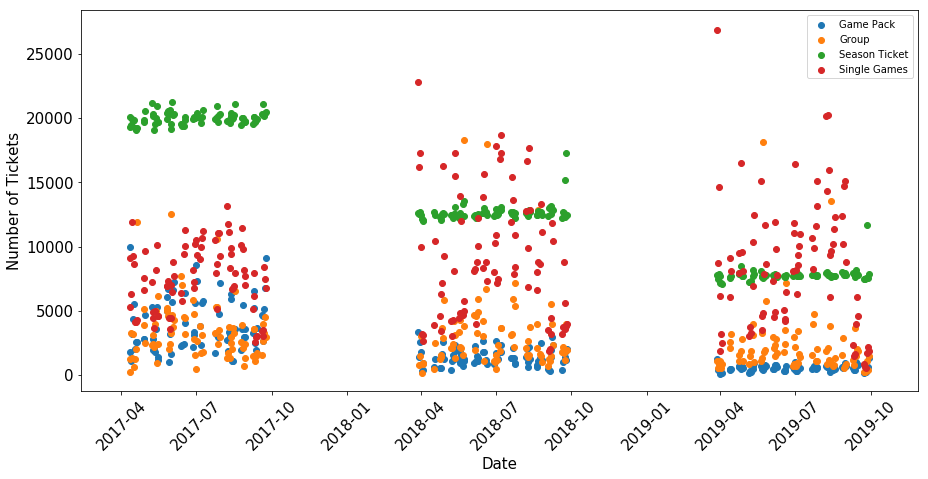

In [49]:
#plot tickets purchased by game date broken up by ticket_type
df_ticketType=all_data.groupby(['game_date', 'ticket_type']).agg({'acct_id':np.size}).rename(columns={'acct_id': 'total_ticket_sales'}).unstack()

fig=plt.figure(figsize=(15,7))
ax1=fig.add_subplot(111)
ax1.scatter(x=df_ticketType.index, y=df_ticketType['total_ticket_sales']['Game Pack'])
ax1.scatter(x=df_ticketType.index, y=df_ticketType['total_ticket_sales']['Group'])
ax1.scatter(x=df_ticketType.index, y=df_ticketType['total_ticket_sales']['Season Ticket'])
ax1.scatter(x=df_ticketType.index, y=df_ticketType['total_ticket_sales']['Single Games'])
plt.legend()
plt.xlabel('Date', size=15)
plt.ylabel('Number of Tickets', size=15)
plt.yticks(size=15)
plt.xticks(size=15, rotation=45)
plt.show()


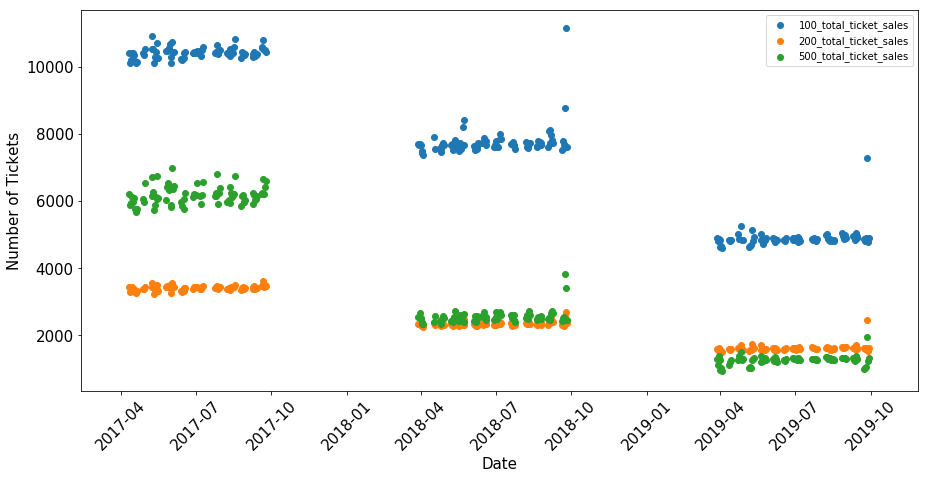

In [50]:
#Plot season tickets purchased broken up by section by game date
season_ticks = all_data[all_data['ticket_type']=='Season Ticket']

df_100 = season_ticks[season_ticks['section_100']==1]
df_200 = season_ticks[season_ticks['section_200']==1]
df_500 = season_ticks[season_ticks['section_500']==1]
df_1=df_100.groupby(['game_date']).agg({'acct_id':np.size,
                                          'ticket_scanned':np.sum}).rename(columns={'acct_id': '100_total_ticket_sales',
                                                                                    'ticket_scanned': 'total_tickets_scanned'})
df_2=df_200.groupby(['game_date']).agg({'acct_id':np.size,
                                          'ticket_scanned':np.sum}).rename(columns={'acct_id': '200_total_ticket_sales',
                                                                                    'ticket_scanned': 'total_tickets_scanned'})
df_5=df_500.groupby(['game_date']).agg({'acct_id':np.size,
                                          'ticket_scanned':np.sum}).rename(columns={'acct_id': '500_total_ticket_sales',
                                                                                    'ticket_scanned': 'total_tickets_scanned'})
fig=plt.figure(figsize=(15,7))
ax1=fig.add_subplot(111)
for i in [1,2,5]:
    exec("ax1.scatter(x=df_{0}.index, y=df_{0}['{0}00_total_ticket_sales'])".format(i))
    plt.legend()
    plt.xlabel('Date', size=15)
    plt.ylabel('Number of Tickets', size=15)
    plt.yticks(size=15)
    plt.xticks(size=15, rotation=45)
plt.show()


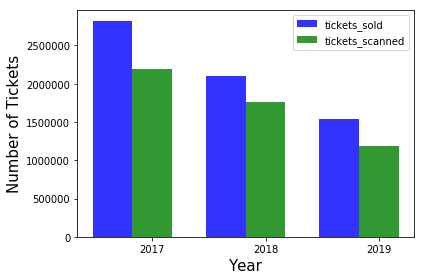

In [51]:
#split by year and get ticket summary
df_2017=all_data[all_data['game_date'].dt.year==2017]
df_2018=all_data[all_data['game_date'].dt.year==2018]
df_2019=all_data[all_data['game_date'].dt.year==2019]

years=[2017, 2018, 2019]
tickets_sold=[df_2017.shape[0], df_2018.shape[0], df_2019.shape[0]]
tickets_scanned=[df_2017[df_2017['ticket_scanned']==1].shape[0], df_2018[df_2018['ticket_scanned']==1].shape[0], df_2019[df_2019['ticket_scanned']==1].shape[0]]

fig, ax = plt.subplots()
index = np.arange(3)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, tickets_sold, bar_width,
alpha=opacity,
color='b',
label='tickets_sold')

rects2 = plt.bar(index + bar_width, tickets_scanned, bar_width,
alpha=opacity,
color='g',
label='tickets_scanned')

plt.xlabel('Year', size=15)
plt.ylabel('Number of Tickets', size=15)
plt.xticks(index + bar_width, years)
plt.legend()

plt.tight_layout()
plt.show()

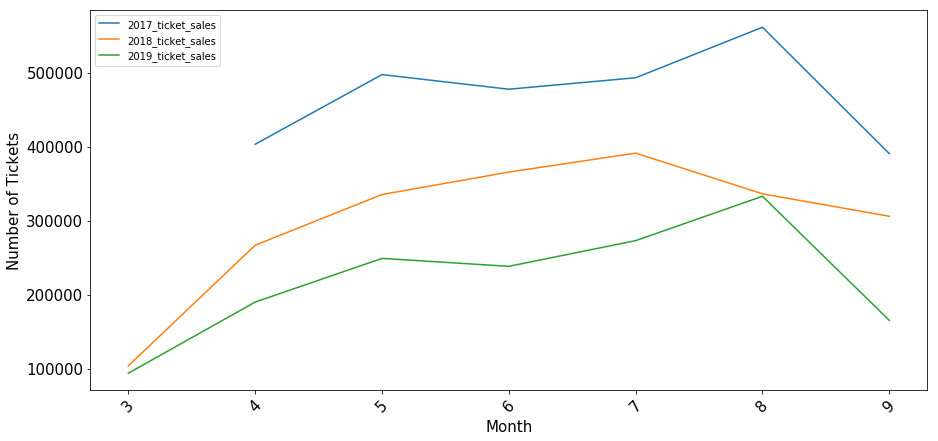

In [52]:
#Ticket Sales by month compared by year
df_2017_month=df_2017.groupby(['game_month']).agg({'acct_id':np.size,
                                                   'ticket_scanned':np.sum}).rename(columns={'acct_id': 'total_ticket_sales',
                                                                                    'ticket_scanned': 'total_tickets_scanned'})
#Distribution of games month
df_2018_month=df_2018.groupby(['game_month']).agg({'acct_id':np.size,
                                                   'ticket_scanned':np.sum}).rename(columns={'acct_id': 'total_ticket_sales',
                                                                                    'ticket_scanned': 'total_tickets_scanned'})
#Distribution of games month
df_2019_month=df_2019.groupby(['game_month']).agg({'acct_id':np.size,
                                                   'ticket_scanned':np.sum}).rename(columns={'acct_id': 'total_ticket_sales',
                                                                                    'ticket_scanned': 'total_tickets_scanned'})
fig=plt.figure(figsize=(15,7))
ax1=fig.add_subplot(111)
ax1.plot(df_2017_month.index, df_2017_month['total_ticket_sales'], label='2017_ticket_sales')
ax1.plot(df_2018_month.index, df_2018_month['total_ticket_sales'], label='2018_ticket_sales')
ax1.plot(df_2019_month.index, df_2019_month['total_ticket_sales'], label='2019_ticket_sales')
plt.legend()
plt.xlabel('Month', size=15)
plt.ylabel('Number of Tickets', size=15)
plt.yticks(size=15)
plt.xticks(size=15, rotation=45)
plt.show()

Text(0, 0.5, 'Number of Tickets Sold')

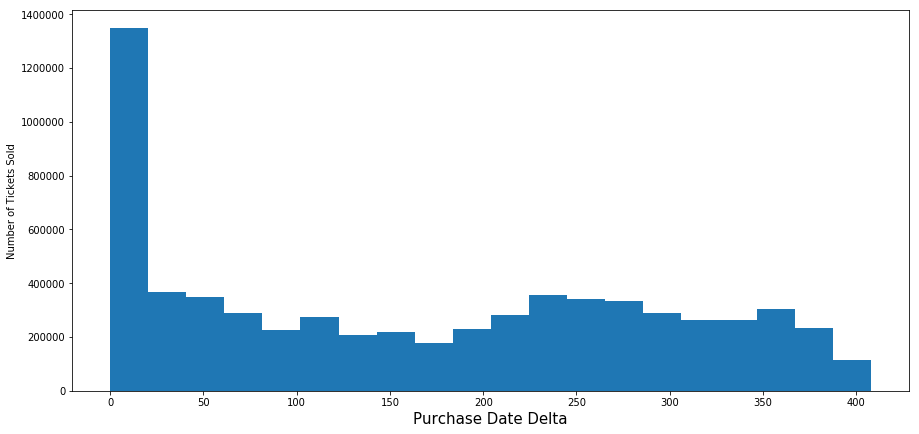

In [53]:
#histogram of purchase date delta (huge portion of tickets purchased within 25-30 days of game)
plt.figure(figsize=(15,7))
plt.hist(all_data['purchase_date_delta'].dt.days, bins=20)
plt.xlabel('Purchase Date Delta', size=15)
plt.ylabel('Number of Tickets Sold')

In [101]:
all_data.to_csv('./Data_Output/all_data.csv', index=False)